In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

from textfab import Conveyer

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk import word_tokenize

%matplotlib inline

In [3]:
df = pd.read_csv("data/twitter_dataset.csv", sep="|")
df = df[df.label != -1]
df.text = df.text.astype(str)


In [4]:
def preprocess(corp):
    con = Conveyer(['remove_non_cyrillic','remove_punct', "lower_string", "swap_enter_to_space", "collapse_spaces"])
    corp = list(map(lambda x:re.sub("[A-Za-z]+", '', x), corp))
    corp = con.start(corp)
    return corp

In [5]:
df = df[df.text != "<no text>"]
#df.text = preprocess(df.text.to_list())

df = df[df.text != ""]

In [6]:
corp = df.text.to_list()

In [7]:
df.label.value_counts()


5    27619
2     2809
1     2131
4      205
3       21
Name: label, dtype: int64

In [8]:
len(corp)

32785

# Emoji distribution

In [9]:
emojis = re.findall("<emoji>[A-Za-z -]+</emoji>", ' '.join(corp))
emojis = list(map(lambda x:re.sub("<emoji>([A-Za-z -]+)</emoji>", "\g<1>", x), emojis))

In [10]:
#hash_tags = re.findall("#[A-Za-zА-Яа-я]+", ' '.join(corp))
#len(set(hash_tags))

In [10]:
len(emojis)

12551

In [11]:
len(set(emojis))

483

In [12]:
from collections import Counter

df_emo = pd.DataFrame()
for emo, num in Counter(emojis).most_common(10): 
    df_emo[emo] = df.text.apply(lambda x: x.count(f"<emoji>{emo}</emoji>") )
df_emo["label"] = df.label

In [13]:
df_emo.head()

,Triangular flag on post,Loudly crying face,Pleading face,Red heart,Sparkles,Place of worship,Beating heart,Clown face,Sparkling heart,Two hearts,label
0,0,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,5


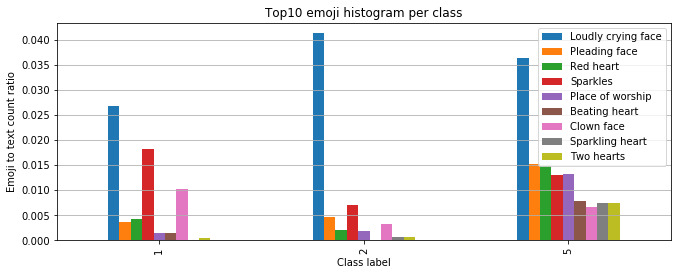

In [14]:
df_emo[df_emo.label.isin([1,2,5])].groupby("label").agg(lambda x: sum(x/len(x))).iloc[:,1:].plot.bar(figsize=((11,4)), )
plt.grid(axis='y')
plt.legend(loc="upper right")
plt.xlabel("Class label")
plt.ylabel("Emoji to text count ratio")
plt.title("Top10 emoji histogram per class")
plt.savefig("emoji", format="png", dpi=600)
#df_emo.groupby("label").agg("sum").iloc[:2,1:].plot.bar(figsize=((7,4)))
#plt.grid(axis='y')


In [15]:
df_emo["Triangular flag on post"].value_counts()[1:].sum()

26

# Message length distr

In [16]:
df["message_length"] = df.text.apply(lambda x: len(x.split()))

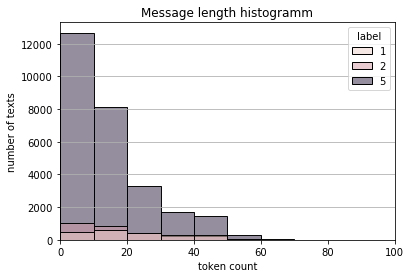

In [17]:
sns.histplot(data=df[df.label.isin([1,2,5])], x="message_length",binwidth = 10, hue="label", stat="count",)

plt.xlim(0,100)
plt.xlabel("token count")
plt.ylabel("number of texts")
plt.title("Message length histogramm")
plt.grid(True, axis="y")
plt.savefig("message_length.pmg", format="png", dpi=600)


(0, 100)

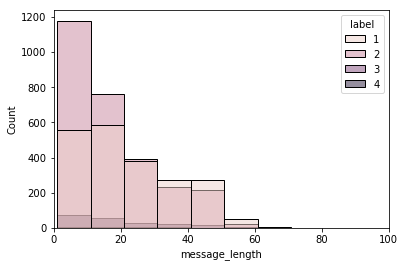

In [18]:
sns.histplot(data=df[df.label != 5], x="message_length",binwidth = 10, hue="label", stat="count",)
plt.xlim(0,100)

# pos-tag patterns

In [34]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from tqdm.auto import tqdm
from collections import Counter
from math import log
from nltk import ngrams
from scipy.stats import mannwhitneyu

In [35]:
russian_stopwords = stopwords.words("russian")


def filter_token_list(token_list, stop_words=None, ngram=1):
    tokens = list(filter(lambda x: x not in punctuation, token_list))
    tokens = list(filter(lambda x: x.isalpha(), tokens))
    if stop_words:
        tokens = list(filter(lambda x: x not in russian_stopwords, tokens))
    #tokens = ['_'.join(x) for x in ngrams(tokens, ngram)]
    return tokens

In [24]:
texts= [pos_tag(filter_token_list(word_tokenize(y)), lang="rus") for y in tqdm(df.text.to_list())]

  0%|          | 0/32785 [00:00<?, ?it/s]

In [25]:
postags = [[y[1] for y in x] for x in texts]

In [26]:
df["pos"] = ["|".join(x) for x in postags]

In [27]:
postags_trigrams = [list(ngrams(x, 3, pad_right=True, right_pad_symbol="<none>")) for x in postags]

postags_trigrams = [list(map(lambda y: "|".join(y), x)) for x in postags_trigrams]

In [28]:
conditional = [Counter() for i in range(len(df.label.unique()))]
for trigram, label in zip(postags_trigrams, df.label.to_list()):
    for t in trigram:
        conditional[label-1][t] += 1

pmi = [Counter() for i in range(len(df.label.unique()))]
for label, label_freq in df.label.value_counts().items():
    label_freq = 1/ label_freq
    print(label)
    for tag in conditional[label-1].keys():
        if conditional[label-1][tag] < 100:
            continue
        else:
            pmi[label-1][tag] = log(1/(conditional[label-1][tag]) / label_freq)

5
2
1
4
3


In [50]:
[x[0] for x in pmi[1].most_common(10)]

['V|S-PRO|ADV',
 'CONJ|V|S-PRO',
 'PR|A-PRO=m|S',
 'ADV|V|S',
 'S|NONLEX|NONLEX',
 'ADV|V|PR',
 'V|CONJ|S',
 'PRAEDIC|<none>|<none>',
 'ADV|V|V',
 'ADV|V|CONJ']

In [72]:
[x[0] for x in pmi[0].most_common(10)]

['V|S-PRO|S',
 'CONJ|S-PRO|S-PRO',
 'CONJ|V|S-PRO',
 'S-PRO|ADV-PRO|V',
 'S|CONJ|PART',
 'V|V|S-PRO',
 'ADV-PRO|S-PRO|V',
 'PART|PART|V',
 'V|CONJ|PR',
 'S|CONJ|PR']

In [73]:
[x[0] for x in pmi[4].most_common(10)]

['PR|V|S',
 'CONJ|ADV|PR',
 'A=pl|S|NONLEX',
 'S-PRO|PR|A-PRO=pl',
 'PRAEDIC|V|<none>',
 'CONJ|S-PRO|A=n',
 'A=n|CONJ|S-PRO',
 'CONJ|CONJ|S',
 'S|S-PRO|A=m',
 'S-PRO|S-PRO|CONJ']

In [47]:
d = pd.DataFrame()
d["label"] = df.label
d = d[~d.label.isin([3,4])]
for i in [x[0] for x in pmi[4].most_common(10)]:
    d[i] = df.pos.apply(lambda x: x.count(i))

In [48]:
class0 = d.groupby("label").agg("sum").transpose()

In [49]:
class0

label,1,2,5
PR|V|S,17,7,141
CONJ|ADV|PR,24,18,135
A=pl|S|NONLEX,5,5,100
S-PRO|PR|A-PRO=pl,6,10,101
PRAEDIC|V|<none>,0,0,0
CONJ|S-PRO|A=n,14,26,101
A=n|CONJ|S-PRO,13,20,102
CONJ|CONJ|S,59,61,367
S|S-PRO|A=m,5,10,102
S-PRO|S-PRO|CONJ,16,18,102


In [51]:
mannwhitneyu(class0[2], class0[5])

MannwhitneyuResult(statistic=9.5, pvalue=0.002422552646036252)

In [51]:
selected_texts = [pos_tag(filter_token_list(word_tokenize(y)), lang="rus") for y in tqdm(df[df.label == 2].text.to_list())]

  0%|          | 0/2809 [00:00<?, ?it/s]

In [52]:
postags_bigrams = [list(ngrams(x, 3, pad_right=True, right_pad_symbol="<none>")) for x in selected_texts]

rearrange_bigram = lambda x:[("_".join([t1[0], t2[0], t3[0]]), "|".join([t1[1], t2[1], t3[1]])) for t1, t2, t3 in x] 

rearrenged = list(map(rearrange_bigram, postags_bigrams))

from itertools import chain
rearrenged_plain = list(chain(*rearrenged))

pos_tags_top_2 = [x[0] for x in pmi[1].most_common(10)]
pos_tags_top_1 = [x[0] for x in pmi[0].most_common(10)]
pos_tags_top_5 = [x[0] for x in pmi[4].most_common(10)]



In [53]:
list(filter(lambda x: x[1] == "V|S-PRO|ADV",rearrenged_plain))#[:30]

[('Кажется_мне_уже', 'V|S-PRO|ADV'),
 ('реализовать_Это_очень', 'V|S-PRO|ADV'),
 ('знаю_я_вообще', 'V|S-PRO|ADV'),
 ('устала_я_сегодня', 'V|S-PRO|ADV'),
 ('делать_вам_больно', 'V|S-PRO|ADV'),
 ('сжирают_меня_изнутри', 'V|S-PRO|ADV'),
 ('смогу_я_скорее', 'V|S-PRO|ADV'),
 ('ок_всем_пока', 'V|S-PRO|ADV'),
 ('гуляю_это_очень', 'V|S-PRO|ADV'),
 ('Понимаете_я_совершенно', 'V|S-PRO|ADV'),
 ('осталось_мне_недолго', 'V|S-PRO|ADV'),
 ('ехать_тем_более', 'V|S-PRO|ADV'),
 ('блять_я_снова', 'V|S-PRO|ADV'),
 ('замечает_что_сложно', 'V|S-PRO|ADV'),
 ('думаю_все_реально', 'V|S-PRO|ADV'),
 ('тупая_Мне_абсолютно', 'V|S-PRO|ADV'),
 ('надеюсь_меня_уже', 'V|S-PRO|ADV'),
 ('простите_я_больше', 'V|S-PRO|ADV'),
 ('блять_я_опять', 'V|S-PRO|ADV'),
 ('могу_это_очень', 'V|S-PRO|ADV'),
 ('делаю_этого_недостаточно', 'V|S-PRO|ADV'),
 ('наела_я_специально', 'V|S-PRO|ADV'),
 ('заебало_всё_уже', 'V|S-PRO|ADV'),
 ('есть_я_уже', 'V|S-PRO|ADV'),
 ('разбивают_меня_психически', 'V|S-PRO|ADV'),
 ('выдержу_я_очень', 'V|S-PRO|

# Capital words analysis

In [28]:
df_['capital'] =  df.text.apply(lambda x: 1 if re.search(r"[А-Я]{2,}", x) != None else 0)

In [29]:
pd.crosstab(df_.label, df_.capital)

capital,0,1
label,,
1,1918,211
2,2562,246
5,24409,2856


In [30]:
chisquare(pd.crosstab(df_.label, df_.capital) )

Power_divergenceResult(statistic=array([34045.87303126,  4168.23121038]), pvalue=array([0., 0.]))

In [31]:
chi2_contingency(pd.crosstab(df_.label, df_.capital) )

(8.457783951984814,
 0.014568523882922024,
 2,
 array([[ 1909.96462953,   219.03537047],
        [ 2519.1078815 ,   288.8921185 ],
        [24459.92748898,  2805.07251102]]))

# Sentiment correlation analysis

In [36]:
def get_sentiments(text:list):
    tokenizer = RegexTokenizer()
    model = FastTextSocialNetworkModel(tokenizer=tokenizer)

    for x in text:
        if not isinstance( x, str):
            print(x)
    
    results = model.predict(text, k=1)
    label = []
    score = []
    for x, y in list([list(x.items())[0] for x in results]):
        label.append(x)
        score.append(y)
    return label, score

In [37]:
sent_label, sent_score = get_sentiments(df.text.apply(lambda x: x.lower()).tolist())
        
df["sentiment"] = sent_label
df["score"] = sent_score


In [38]:
df = df[~df.sentiment.isin(["skip", "speech"])]
sent2score = {"neutral": 0, "negative": -1, "positive": 1}
df["sentiment"] = df.sentiment.apply(lambda x: sent2score[x])

In [65]:
chi2_contingency(pd.crosstab(df_.label, df_.sentiment))

(1029.8912577797319,
 1.1872955235190992e-221,
 4,
 array([[ 558.38820134,  817.69021181,  224.92158685],
        [ 689.87624126, 1010.23812552,  277.88563322],
        [5881.7355574 , 8613.07166267, 2369.19277992]]))

In [41]:
chisquare(pd.crosstab(df.label, df.sentiment))
chi2_contingency(pd.crosstab(df.label, df.sentiment))

(1526.1681897032545,
 0.0,
 8,
 array([[6.63162332e+02, 1.04029491e+03, 2.78542756e+02],
        [8.80647456e+02, 1.38146126e+03, 3.69891288e+02],
        [6.35725747e+00, 9.97255466e+00, 2.67018787e+00],
        [6.12304272e+01, 9.60514475e+01, 2.57181253e+01],
        [8.39760253e+03, 1.31732198e+04, 3.52717764e+03]]))

In [44]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


In [45]:
cramers_v(pd.crosstab(df.label, df.sentiment).values)

0.1593023498288088

# Capital vs sentiment

In [72]:
chi2_contingency(pd.crosstab(df_.capital, df_.sentiment))

(104.71329416782757,
 1.8272462551845212e-23,
 2,
 array([[6389.5514357 , 9356.70498459, 2573.74357971],
        [ 740.4485643 , 1084.29501541,  298.25642029]]))

In [75]:
pd.crosstab(df_.capital, df_.sentiment)

sentiment,-1,0,1
capital,,,
0,6199,9572,2549
1,931,869,323


In [73]:
chisquare(pd.crosstab(df_.capital, df_.sentiment))

Power_divergenceResult(statistic=array([3892.26143058, 7254.30600517, 1725.30501393]), pvalue=array([0., 0., 0.]))

In [74]:
cramers_v(pd.crosstab(df_.capital, df_.sentiment).values)

0.07088452453947905

# Vocab induction

## Specific words induction

In [20]:
df = pd.concat([pd.read_csv("data/mokoron/negative.csv", sep=";", header=None),
                pd.read_csv("data/mokoron/positive.csv", sep=";", header=None)])

In [21]:
ref_corp = df[3].to_list()

In [22]:
df = pd.read_csv("data/twitter_dataset.csv", sep="|")
df.text = df.text.astype(str)
df = df[df.text != "<no text>"]
corp = df.text.to_list()

In [23]:
def get_common_words_intersect(lst1, lst2):
    c1 = Counter(lst1)
    c2 = Counter(lst2)
    return Counter({ k: c1[k] + c2[k] for k in c1.keys() & c2.keys() }), c1, c2

list2words = lambda x: word_tokenize(' '.join(x))

In [24]:
#corp = df.text.to_list()
def preprocess(corp):
    con = Conveyer(['remove_punct', "lower_string", "swap_enter_to_space", "collapse_spaces"])
    corp = list(map(lambda x: re.sub(r"<emoji>.+</emoji>", "", x), corp))
    corp = list(filter(lambda x: "<no text>" not in x, corp))
    corp = list(map(lambda x:re.sub("[A-Za-z]+", '', x), corp))
    #corp = list(map(lambda x:re.sub("[^А-Яа-я]+", '', x), corp))
    #corp = list(filter(lambda x: x.isalpha(), corp))
    corp = con.start(corp)
    corp = list(filter(lambda x: len(x) > 2, corp))
    return corp

def preprocess(corp):
    con = Conveyer([("remove_custom_regex", ["<emoji>.+</emoji>"]),
                    ("remove_custom_regex", ["[A-Za-z]+]"]),
                    'remove_non_cyrillic',
                    'remove_punct', 
                    "lower_string", 
                    "swap_enter_to_space",
                    "lemmatize_by_mystem"
                    "collapse_spaces",])
    #corp = list(map(lambda x: re.sub(r"<emoji>.+</emoji>", "", x), corp))    
    #corp = list(map(lambda x:re.sub("[A-Za-z]+", '', x), corp))
    corp = con.start(corp)
    #corp = list(filter(lambda x: len(x) > 2, corp))
    return corp

con_vocab_induction = Conveyer([("remove_custom_regex", ["<emoji>.+</emoji>"]),
                    ("remove_custom_regex", ["[A-Za-z]+]"]),
                    'remove_non_cyrillic',
                    'remove_punct', 
                    "lower_string", 
                    "swap_enter_to_space",
                    "lemmatize_by_mystem",
                    "collapse_spaces",])

In [25]:
ref_corp = con_vocab_induction.start(ref_corp)
corp = con_vocab_induction.start(corp)

In [26]:
ref_corp_tokens = list2words(ref_corp[:len(corp)])
corp_tokens = list2words(corp)

In [27]:
c = Counter(corp_tokens)
cc = []
for i in set(corp_tokens) - set(ref_corp_tokens):
    cc.append((i, c[i]))

In [28]:
cc.sort(key=lambda x: x[1], reverse=True)

In [29]:
cc[:20]

[('мема', 102),
 ('дазай', 97),
 ('геншин', 82),
 ('мью', 81),
 ('тикток', 76),
 ('краш', 74),
 ('рп', 65),
 ('хорня', 63),
 ('дилюк', 57),
 ('вайба', 55),
 ('бсд', 52),
 ('ментальный', 50),
 ('секси', 50),
 ('пж', 49),
 ('рпп', 48),
 ('атсума', 48),
 ('фд', 46),
 ('осама', 45),
 ('эстетика', 43),
 ('косплей', 40)]

In [69]:
#wordcloud = WordCloud(width=800, height=600, collocations=False).generate(text)
#wordcloud.to_image()

## Applying HTZ

In [30]:
from math import log
import numpy as np

In [72]:
texts = df.text.to_list()
texts = con_vocab_induction.start(texts)
#texts = np.array([word_tokenize(x) for x in texts])

In [80]:
#texts = [word_tokenize(x) for x in texts]
texts = [list(filter(lambda x: len(x) > 1, y)) for y in texts]
texts = np.array(texts)

/tmp/ipykernel_18293/399976994.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  texts = np.array(texts)


In [82]:
texts.shape

(32785,)

In [83]:
def get_idf(texts: list):
    idf = Counter()
    for t in texts:
        for w in set(t):
            idf[w] += 1
    for w in idf:
        idf[w] = log(len(texts)/idf[w], 2)
    return idf

In [84]:
from typing import Union

def heaviside(x: Union[int, float]):
    if x< 0:
        return 0
    elif x == 0:
        return 0.5
    else:
        return x

def get_htz(text_inclass: list, text_outclass: list):
    metric = []
    t1 = get_idf(text_inclass)
    t2 = get_idf(text_outclass)
    for w in t1:
        delta = t2[w] - t1[w]
        metric.append( (w, delta * heaviside(delta)) )
    metric.sort(key = lambda x: x[1], reverse=True)

    return metric

In [87]:
lexicon = {1:[], 2:[], 5:[]}
for label in lexicon:
    in_class = texts[df[df.label == label].index]
    out_class = texts[df[df.label != label].index]
    
    lexicon[label] = [x[0] for x in get_htz(in_class, out_class)][:20]

In [88]:
pd.DataFrame(lexicon)

,1,2,5
0,прл,сато,мью
1,антидепрессант,чудовище,чуять
2,рвота,усталый,сезон
3,больничка,медосмотр,вайба
4,галлюцинация,поплакать,хорня
5,побочка,подпускать,добавлять
6,бессонница,забиваться,картинка
7,частичка,унижение,читатель
8,кп,подавлять,вкус
9,порез,комок,ау


In [31]:
def preprocess(corp):
    con = Conveyer(['remove_punct', "lower_string", "swap_enter_to_space", "collapse_spaces"])
    #r = re.compile("|".join([f"({x})" for x in russian_stopwords]))
    corp = list(map(lambda x: re.sub(r"<emoji>.+</emoji>", "", x), corp))
    corp = list(filter(lambda x: "<no text>" not in x, corp))
    corp = list(map(lambda x:re.sub("[A-Za-z]+", '', x), corp))
    #corp = list(map(lambda x: re.sub(r, "", x), corp))
    #corp = list(map(lambda x:re.sub("[^А-Яа-я]+", '', x), corp))
    #corp = list(filter(lambda x: x.isalpha(), corp))
    corp = con.start(corp)
    corp = list(filter(lambda x: len(x) > 2, corp))
    return corp

## Applying RTD

In [223]:
#ref_corp = preprocess(ref_corp)
#corp = preprocess(corp)

In [224]:
#ref_corp_tokens = list2words(ref_corp[:len(corp)])
#corp_tokens = list2words(corp)

In [32]:
ref_corp_tokens = list(filter(lambda x: x.isalpha(), ref_corp_tokens))
corp_tokens = list(filter(lambda x: x.isalpha(), corp_tokens))

In [36]:
russian_stopwords += ["который", "оо", "ещ"]

In [37]:
ref_corp_tokens = list(filter(lambda x: x not in russian_stopwords, ref_corp_tokens))
corp_tokens = list(filter(lambda x: x not in russian_stopwords, corp_tokens))

In [38]:
common_words, corp1_freq, corp2_freq  = get_common_words_intersect(corp_tokens,ref_corp_tokens)
common_words = common_words.most_common()
common_words = [x[0] for x in common_words]
tokens_df1_freq = []
tokens_df2_freq = []

corp1_freq = [x[0] for x in corp1_freq.most_common()]
corp2_freq = [x[0] for x in corp2_freq.most_common()] 
for w in common_words:
    try:
        tokens_df1_freq.append(corp1_freq.index(w) +1)
        tokens_df2_freq.append(corp2_freq.index(w) + 1)
    except:
        print(w)
        continue
tokens_df1_freq = np.array(tokens_df1_freq)
tokens_df2_freq = np.array(tokens_df2_freq)

alpha = 0.3
unnormilized_divergance = np.abs(1 / (tokens_df1_freq ** alpha) - 1 / (tokens_df2_freq ** alpha)) ** (1 / (alpha+1))
norm_tern_1 = (alpha+1) / alpha * np.sum( np.abs( 1/(tokens_df1_freq ** alpha) - 1/ ( ( tokens_df1_freq.shape[0] + 0.5 *  tokens_df2_freq.shape[0]) ** alpha)  ) **(1/(alpha+1)) )
norm_tern_2 = (alpha+1) / alpha * np.sum( np.abs( 1/ ( ( tokens_df2_freq.shape[0] + 0.5 *  tokens_df1_freq.shape[0]) ** alpha) - 1/(tokens_df2_freq ** alpha) ) **(1/(alpha+1)) )
norm = norm_tern_1 + norm_tern_2
rde =  1 / norm * (alpha + 1) / alpha * unnormilized_divergance

In [39]:
t = list(zip(common_words,rde))

In [40]:
t.sort(key=lambda x: x[1], reverse=True)

In [41]:
top_rtd = []
for i, (w, d) in enumerate(t):
    top_rtd.append((i, w, d*10000, corp1_freq.index(w), corp2_freq.index(w)))

In [42]:
pd.DataFrame(top_rtd, columns=["index", "word", "rtd", "rank in our corpus", "rank in common one"]).head(50)

,index,word,rtd,rank in our corpus,rank in common one
0,0,блять,3.070408,7,175
1,1,завтра,2.429647,70,8
2,2,блин,2.403365,82,9
3,3,нахуй,1.968482,44,745
4,4,болеть,1.941925,136,19
5,5,скучать,1.834642,517,44
6,6,сегодня,1.688969,15,5
7,7,человек,1.632923,4,11
8,8,жаль,1.553837,429,57
9,9,жалко,1.553346,1075,92
